<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/drugVAE/chemVAE%2BKL_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -R 'molecular-vae'
!git clone https://github.com/aksub99/molecular-vae.git
import zipfile
zip_ref = zipfile.ZipFile('molecular-vae/data/processed.zip', 'r')
zip_ref.extractall('molecular-vae/data/')
zip_ref.close()

rm: cannot remove 'molecular-vae': No such file or directory
Cloning into 'molecular-vae'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 185
Receiving objects: 100% (188/188), 2.99 MiB | 28.32 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection
from tqdm import tqdm

In [3]:
h5f = h5py.File('/content/molecular-vae/data/processed.h5', 'r')
data = h5f['data_test'][:] # (10000, 120, 33)

In [4]:
charset = h5f['charset'][:]
charset

array([b' ', b'#', b')', b'(', b'+', b'-', b'/', b'1', b'3', b'2', b'5',
       b'4', b'7', b'6', b'=', b'@', b'C', b'B', b'F', b'I', b'H', b'O',
       b'N', b'S', b'[', b']', b'\\', b'c', b'l', b'o', b'n', b's', b'r'],
      dtype='|S1')

In [5]:
def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

In [7]:
from torch.autograd import Variable
max_len = 120 # max_len of molecule
alphabet_len = len(charset)

class MolecularVAE(nn.Module):
    def __init__(self, in_dim=[250, max_len, alphabet_len], z_dim=292):
        """
        param: in_dim = [batch_size, max_len, len(alphabet)]
        param: z_dim: z dimension
        """

        super(MolecularVAE, self).__init__()

        (_, max_len, alphabet_len) = in_dim
        self.max_len = max_len
        self.alphabet_len = alphabet_len
        self.kld = 0

        self.conv_1 = nn.Conv1d(max_len, 9, kernel_size = 9) #[bs, 9, 25]
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9) # [bs, 9, 17]
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11) # [bs, 10, 7]
        self.linear_0 = nn.Linear(70, 435)
        self.mu = nn.Linear(435, z_dim)
        self.logvar = nn.Linear(435, z_dim)

        self.linear_3 = nn.Linear(z_dim, z_dim)
        self.gru = nn.GRU(z_dim, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, alphabet_len)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()


    def encode(self, x):

        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1) # (batch_size, size(-2) * size(-1))
        # print('after view', x.shape)
        x = F.selu(self.linear_0(x))

        mu = self.mu(x)
        logvar = F.softplus(self.logvar(x))
        return mu, logvar

    def reparametrize(self, mu, logvar):
        epsilon = Variable(torch.rand(mu.size()), requires_grad=False)
        if mu.is_cuda: epsilon = epsilon.cuda()
        std = logvar.mul(0.5).exp_()
        z = mu.addcmul(std, epsilon)
        return z

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.max_len, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def update_kld(self, mu, logvar):
        self.kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    def get_kld(self):
        return self.kld

    def forward(self, x):
        mu, logvar = self.encode(x)
        self.update_kld(mu, logvar)
        z = self.reparametrize(mu, logvar)
        return self.decode(z)

# from torchsummary import summary

# summary(MolecularVAE(), (250,120, 33))
MolecularVAE()

MolecularVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (linear_0): Linear(in_features=70, out_features=435, bias=True)
  (mu): Linear(in_features=435, out_features=292, bias=True)
  (logvar): Linear(in_features=435, out_features=292, bias=True)
  (linear_3): Linear(in_features=292, out_features=292, bias=True)
  (gru): GRU(292, 501, num_layers=3, batch_first=True)
  (linear_4): Linear(in_features=501, out_features=33, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [8]:
# n = nn.Conv1d(max_len, 9, kernel_size = 9)
# a = torch.randn(250, max_len, alphabet_len)
# out = n(a)
# print(out.size())
# n1 = nn.Conv1d(9, 9, kernel_size=9)
# out = n1(out)
# print(out.size())
# n2 = nn.Conv1d(9, 10, kernel_size=11)
# out = n2(out)
# print(out.size())
import numpy as np
import math
import matplotlib.pyplot as plt
import os
def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L


In [9]:
data_train, data_test, charset = load_dataset('molecular-vae/data/processed.h5')
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)

torch.manual_seed(42)
data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=250, shuffle=True)


cuda = torch.cuda.is_available()

device = 'cuda' if cuda else 'cpu'



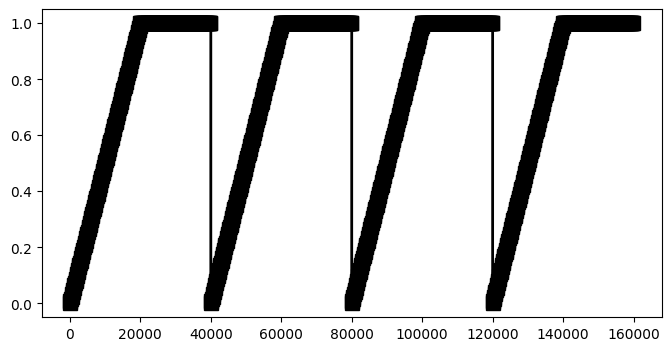

In [35]:
batch_size = 250
epochs= 1000
n_epoch = int(len(train_loader)*epochs)

beta_np_cyc = frange_cycle_linear(0.0, 1.0, n_epoch, 4)

fig=plt.figure(figsize=(8,4.0))
stride = max(int(n_epoch / epochs), 1)

plt.plot(range(n_epoch), beta_np_cyc, '-',
         label='Cyclical', marker= 's', color='k',
         markevery=stride,lw=2,  mec='k', mew=1 , markersize=10)

In [21]:
len(train_loader), len(train_loader.dataset)

(160, 40000)

In [42]:
model = MolecularVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

def train(epoch, beta_kl=beta_np_cyc):
    model.train()
    train_loss = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader),
                        desc=f'epoch {epoch}'):
        data = data[0].to(device)
        optimizer.zero_grad()
        output = model(data)

        BCE = F.binary_cross_entropy(output, data, reduction='sum')
        KLD = model.get_kld()
        beta = beta_kl[i*epoch]
        loss = BCE + beta * KLD
        loss.backward()
        train_loss += loss.data.item()
        optimizer.step()


    train_loss = train_loss/len(train_loader.dataset)
    print(f'train \t loss: {train_loss:.3f}  KLD beta: {beta:.3f}')
    return train_loss

def test(epoch):
    model.eval()
    test_loss = 0
    for data in test_loader:
        data = data[0].to(device)
        output = model(data)
        loss = F.binary_cross_entropy(output, data,
                                      reduction='sum') + model.get_kld()
        test_loss += loss.data.item()

    test_loss /= len(test_loader.dataset)
    print(f'test \t loss: {test_loss:.3f}')
    return test_loss



In [14]:
# len(test_loader.dataset)

10000

In [43]:
# loss_dict = {}
# loss_dict[1] = [12, 2]
# loss_dict[2] = [3, 1]

# fig = plt.figure()
# train_losses = np.array(list(loss_dict.values()))[:, 0]
# test_losses = np.array(list(loss_dict.values()))[:, 1]
# plt.plot(list(loss_dict.keys()), train_losses, label='train')
# plt.plot(list(loss_dict.keys()), test_losses , label='test')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.title('loss during training')
# plt.legend()
# plt.show()

def get_min(d:dict):

    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key is greater than the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()

filepath = '/content/drive/MyDrive/A_MODEL/chemVAE/'

def save_pkl(a:dict, filename=filepath+'filename.pickle'):
    import pickle
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # with open('filename.pickle', 'rb') as handle:
    #     b = pickle.load(handle)

    # print(a == b)

epoch 0: 100%|██████████| 160/160 [00:45<00:00,  3.55it/s]


train 	 loss: 142.096  KLD beta: 0.000
test 	 loss: 342.075


epoch 1: 100%|██████████| 160/160 [00:47<00:00,  3.37it/s]


train 	 loss: 120.804  KLD beta: 0.008
test 	 loss: 199.726


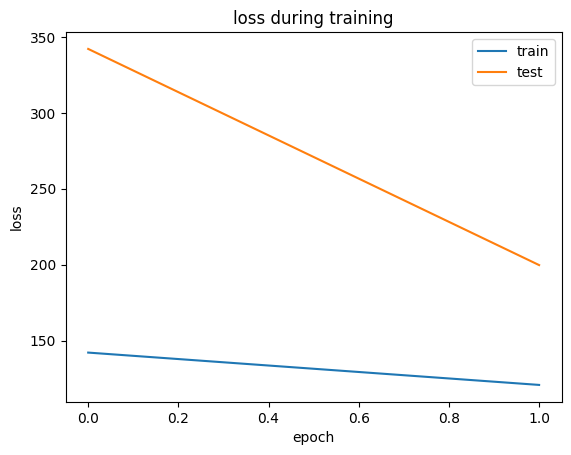

epoch 2: 100%|██████████| 160/160 [00:50<00:00,  3.16it/s]


train 	 loss: 116.219  KLD beta: 0.016
test 	 loss: 161.984


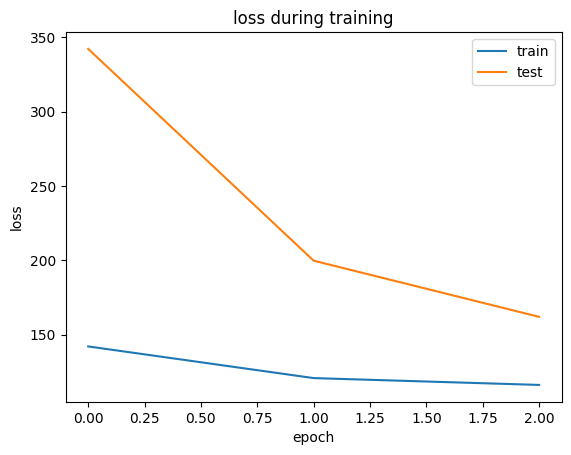

epoch 3:  36%|███▋      | 58/160 [00:17<00:31,  3.22it/s]

In [ ]:
train_dict, test_dict = {}, {}
model_path = '/content/drive/MyDrive/A_MODEL/chemVAE/'
for epoch in range(epochs):
    train_dict[epoch] = train(epoch)
    if epoch % 1 == 0:
        test_dict[epoch] = test(epoch)
        if epoch != 0:
            plot_loss(train_dict, test_dict)
            argmin_epoch, min_loss = get_min(test_dict)
            save_pkl(train_dict, filename=model_path+'train_loss.pickle')
            save_pkl(test_dict, filename=model_path+'test_loss.pickle')

            if test_dict[epoch] <= min_loss and epoch > 10:
                torch.save(model.state_dict(),
                           model_path+f'ckpt_{str(epoch)}.pt')
                print('model save at: ',  model_path+f'ckpt_{str(epoch)}.pt')
            else:
                if epoch - argmin_epoch > 10:
                    print('early stop, loss no decrease')
                    break
                if test_dict[epoch] / min_loss > 1.3:
                    print(f'early stop, loss increase')
                    break


In [40]:
1 <= 2

True

In [27]:
test_losses = list(test_dict.values())
test_epoches = list(test_dic)

dict_values([226.543886328125, 118.57206484375, 112.3496333984375, 109.2369900390625, 106.9527314453125])

In [29]:
import copy
d = copy.deepcopy(test_dict)



get_min(d)

(12, 106.9527314453125)

In [23]:
data

[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 

In [25]:
data[0].shape

torch.Size([250, 120, 33])

In [29]:
a=data[0].view(data[0].size(0), -1)

In [32]:
a.size(0)

250

In [35]:
new_a = a.view(a.size(0), 1, a.size(-1)).repeat(1, 120, 1)

In [37]:
new_a.shape

torch.Size([250, 120, 3960])